Fractals can be thought of in the simplest terms as geometric objects that have a most peculiar and magical property, that of a self-similarity or recursive pattern in their structure when observed across different scales - i.e. the structure appears the same even when the object is magnified. Interestingly, fractals appear quite regularly in nature for example that of the Romanesco Brocolli to the shapes of coastlines. It is the latter topic that will be the focal point of investigation in this notebook, where I will examine how fractal-like are the shapes of coastlines of different countries.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import base64
import codecs
import cv2
from scipy import misc
%matplotlib inline

In [5]:
import os
from PIL import Image
import imageio
from io import BytesIO

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [7]:
def create_b64_images(im_path='images', im64_path='images64'):
    img_paths = []
    for d, _, f in os.walk(im_path):
        for file in f:
            img_path = os.path.join(d, file)

            with open(img_path, 'rb') as image_file:
                data = base64.b64encode(image_file.read())
                
            im = Image.open(BytesIO(base64.b64decode(data)))
            im_64_path_name = os.path.join(im64_path,
                                      file.split('.')[0]+'_b64.png')
            print('Updated...', im_64_path_name)
            img_paths.append(im_64_path_name)
            im.save(im_64_path_name)
    return img_paths
im_new_paths = create_b64_images()

Updated... images64\f0_b64.png
Updated... images64\f1_b64.png
Updated... images64\f2_b64.png
Updated... images64\f3_b64.png
Updated... images64\f4_b64.png
Updated... images64\f5_b64.png


In [8]:
def plot_image_cv2(image, img_type='normal'):
    '''
    img_type =  'normal' -> plot in RGB format
            'gray'   -> plot in GRAY format
    '''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if img_type=='normal':
        plt.imshow(image)
    elif img_type=='gray':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        plt.imshow(image, cmap='gray')
    else:
        raise ValueError("img_type not 'normal' or 'gray'")

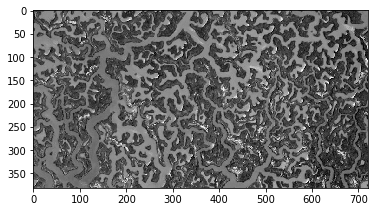

In [9]:
# generating mask for satellite images
f0 = cv2.imread(im_new_paths[0])
plot_image_cv2(f0, img_type='gray')

In [10]:
def gray_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

In [11]:
# Otsu's thresholding after Gaussian filtering
def otsu_thresh(image, thresh=0):
    
    gray = gray_image(image)
    
    blur = cv2.GaussianBlur(gray,(5,5),0)
    
    ret3,th3 = cv2.threshold(blur, thresh, 255,
                             cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return gray, blur, th3

In [12]:
def plot_otsu_thresh(image):
    
    gray, blur, th3 = otsu_thresh(image)

    # map thresholding
    plt.figure(figsize=(15, 5))
    images = [blur, 0, th3]
    titles = ["Gaussian filtered Image",
              "Histogram",
              "Otsu's Thresholding"]

    plt.subplot(1,3,1)
    plt.imshow(images[0], 'gray')
    plt.title(titles[0])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,3,2)
    plt.hist(images[0].ravel(), 256)
    plt.title(titles[1])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,3,3)
    plt.imshow(images[2], 'gray')
    plt.title(titles[2])
    plt.xticks([])
    plt.yticks([])

In [13]:
### Box Counting to estimate the Fractal dimension
def boxcount(Z, k):
    S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k),
                           axis=0),
            np.arange(0, Z.shape[1], k),
            axis=1
    )
    
    return len(np.where((S > 0) & (S < k*k))[0])

In [14]:
def fractal_dimension(Z, threshold=0.9):
    
    Z = (Z < threshold)
    
    p = min(Z.shape)
    
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))
    
    sizes = 2**np.arange(n, 1, -1)
    
    counts = []
    
    for size in sizes:
        counts.append(boxcount(Z, size))
    
    coeffs = np.polyfit(np.log(sizes),
                        np.log(counts), 1)
    
    return -coeffs[0]

In [15]:
def hsv_graph_3d(im_new_path):
    
    im_demo = cv2.imread(im_new_path)
    im_demo = cv2.cvtColor(im_demo, cv2.COLOR_BGR2RGB)
    im_demo = cv2.cvtColor(im_demo, cv2.COLOR_RGB2HSV)

    pixel_colors = im_demo.reshape((np.shape(im_demo)[0]*np.shape(im_demo)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    h, s, v = cv2.split(im_demo)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel("Hue")
    axis.set_ylabel("Saturation")
    axis.set_zlabel("Value")
    plt.show()

In [16]:
def show_fractal(image_path):
    
    image = cv2.imread(image_path)
    
    gray = gray_image(image)
    
    plot_otsu_thresh(image)
    
    Z = 1.0 - gray/255.
    sizes = 128, 64, 28
    
    # sizes = 32, 16, 8
    xmin, xmax = 0, Z.shape[1]
    ymin, ymax = 0, Z.shape[0]
    fig = plt.figure(figsize=(16, 11))
    plt.title('Box Counting Fractal Method')
    for i, size in enumerate(sizes):
        ax = plt.subplot(1, len(sizes), i+1, frameon=False)
        ax.imshow(1-Z, plt.cm.gray, interpolation="bicubic", vmin=0, vmax=1,
                  extent=[xmin, xmax, ymin, ymax], origin="upper")
        ax.set_xticks([])
        ax.set_yticks([])
        for y in range(Z.shape[0]//size+1):
            for x in range(Z.shape[1]//size+1):
                s = (Z[y*size:(y+1)*size, x*size:(x+1)*size] > 0.25).sum()
                if s > 0 and s < size*size:
                    rect = patches.Rectangle(
                        (x*size, Z.shape[0]-1-(y+1)*size),
                        width=size, height=size,
                        linewidth=.5, edgecolor='.25',
                        facecolor='.75', alpha=.5, color='lightblue')
                    ax.add_patch(rect)
                    
    

    plt.tight_layout()
    

    print("The Fractal dimension of the coastline image is {}".format(
        fractal_dimension(Z, threshold=0.1)))

D:\anaconda\envs\new\lib\site-packages\matplotlib\patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


The Fractal dimension of the coastline image is 0.7962591648406997


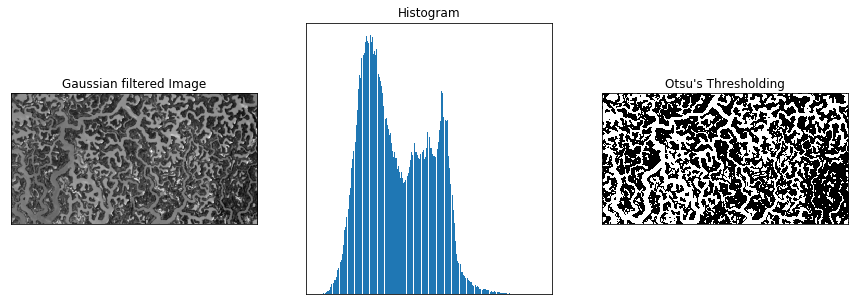

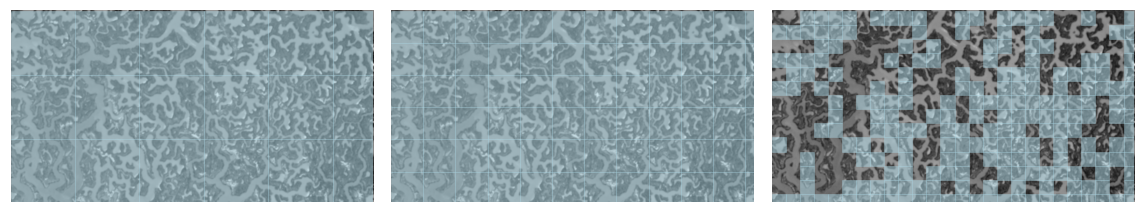

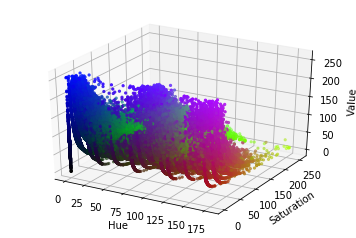

------------------------------------------------------------------------------------------------------------------------


In [17]:

show_fractal(im_new_paths[0])
hsv_graph_3d(im_new_paths[0])
print('-'*120)